# Data Preparation for Fitting a Full SED with diskSED

This tutorial explains how to prepare data for fitting a full Spectral Energy Distribution (SED), including X-ray spectra and UV/optical photometry, using diskSED.  
We use the first epoch of ASASSN-14li, as defined in [arXiv:2408.17296](https://arxiv.org/abs/2408.17296).  
The required data can be found at `.../diskSED/examples/data`.


# Required Files for diskSED

To run a fitting with diskSED, we need two main files:

1. **Grouped/Binned X-ray Spectrum:**  
   - This file should be linked to other X-ray files, such as ARF (Auxiliary Response Files), RMF (Redistribution Matrix Files), and the background spectrum.  
   - Grouping or binning is required because, in this tutorial, we aim to perform fitting using Gaussian statistics. XSPEC does not support fitting UV/optical data with Poisson statistics.

> **Note:** In principle, one could write a hybrid likelihood function to fit unbinned X-ray spectra using Poisson statistics and UV/optical data using Gaussian statistics. However, this is beyond the scope of this tutorial.

2. **UV/Optical SED File:**  
   - This file must be in a format readable by pyXSPEC.  
   - It should have an accompanying dummy (diagonal) RMF file.  
   - Reduced, host-subtracted (but not extinction corrected) data from the source is recommended.


In [41]:
# Enable interactive plotting
%matplotlib widget # if this does not work, try e.g. matplotlib notebook.

# Import essential libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import MaxNLocator
import os

# Optional: Customize plotting style for better visuals
plt.rcParams['font.size'] = 25
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# Store current working directory
cwd = os.getcwd()


# Grouping the X-ray Spectrum

To group the X-ray spectrum, we will use **HEASoft's ftgrouppha** tool.  
More details can be found in the [official documentation](https://heasarc.gsfc.nasa.gov/lheasoft/help/ftgrouppha.html).


In [42]:
# Navigate to the folder containing SED data
os.chdir(os.path.join(cwd, 'data', 'SED'))

# List all files in the current directory to verify contents
os.system('ls')


14li_E1_arf.fits
14li_E1_bkg.fits
14li_E1_pha.fits
14li_E1_rmf.fits
uvopt.dat
uvopt.pha
uvopt.rmf


0

In [43]:
# Defining file names for X-ray spectrum components
pha = '14li_E1_pha.fits'
bkg = '14li_E1_bkg.fits'
arf = '14li_E1_arf.fits'
rmf = '14li_E1_rmf.fits'

# Output grouped spectrum file
grp_output = '14li_E1_grp.fits'

# Run ftgrouppha to group the X-ray spectrum
os.system('ftgrouppha ' +
          str(pha) + ' ' +
          'backfile=' + str(bkg) + ' ' +
          'outfile=' + str(grp_output) + ' ' +
          'respfile=' + str(rmf) + ' ' +
          'grouptype=optmin ' +  # Optimal binning scheme (Kaastra+16)
          'groupscale=10'  # Minimum number of counts per bin
         )

# Alternatively, print the command for manual execution in the terminal
print('ftgrouppha ' +
      str(pha) + ' ' +
      'backfile=' + str(bkg) + ' ' +
      'outfile=' + str(grp_output) + ' ' +
      'respfile=' + str(arf) + ' ' +
      'grouptype=optmin ' +
      'groupscale=10'
     )

# Return to the main working directory
os.chdir(cwd)

# Done: The grouped spectrum file is now ready.


ftgrouppha 14li_E1_pha.fits backfile=14li_E1_bkg.fits outfile=14li_E1_grp.fits respfile=14li_E1_arf.fits grouptype=optmin groupscale=10


# Creating a UV/Optical SED File

To create a UV/optical SED file, we will use **HEASoft's ftflx2xsp** tool.  
More details can be found in the [official documentation](https://heasarc.gsfc.nasa.gov/lheasoft/help/ftflx2xsp.html).


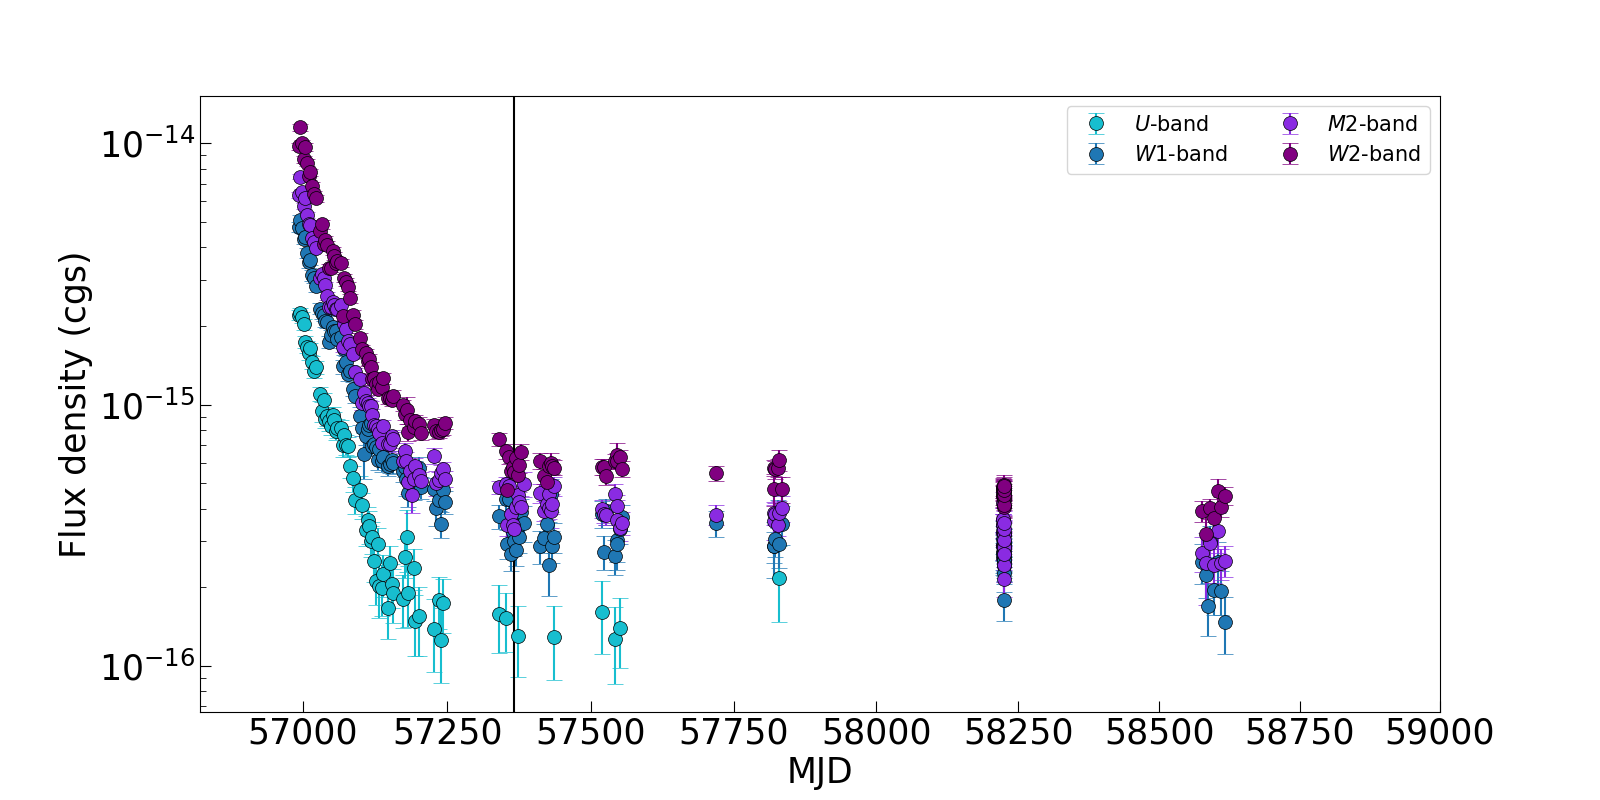

In [44]:
# Typically, we extract a UV/optical SED from a light curve spanning multiple bands.
# Ensure data is in flux density units, preferably erg/cm^2/s/Å.

# Plotting the light curve for ASASSN-14li

fig, ax = plt.subplots(figsize=(16, 8))

# Available bands in the dataset
bands = ['sw_uu', 'sw_w1', 'sw_m2', 'sw_w2']

# Define labels and colors for each band
colors = ['tab:cyan', 'tab:blue', 'blueviolet', 'purple']
labels = [r'$U$-band', r'$W1$-band', r'$M2$-band', r'$W2$-band']

# Plot each band
for i, band in enumerate(bands):
    obs_id, mjd, abmag, abmage, flux_dens, fluxe_dens_err, _ = np.loadtxt(
        os.path.join(cwd, 'data', 'light_curve', f'{band}.txt'),
        skiprows=3,
        unpack=True
    )
    # Basic signal-to-noise flag
    det = (flux_dens > 3 * fluxe_dens_err) & (fluxe_dens_err > 0)
    ax.errorbar(
        mjd[det], flux_dens[det],
        yerr=fluxe_dens_err[det],
        ls='',
        marker='o',
        capsize=6,
        mec='black',
        mew=0.5,
        color=colors[i],
        ms=10,
        label=labels[i]
    )

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(None, 59000)
ax.set_xticks(np.arange(57000, 59250, 250))
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
ax.set_xlabel('MJD')
ax.set_ylabel('Flux density (cgs)')
ax.legend(loc='upper right', frameon=True, fontsize=15, ncol=2)

# Mark the epoch corresponding to the X-ray spectrum
from astropy.time import Time

E1_time = ['2015-12-10T11:42:38'] # This is in the header of the X-ray observation
E1_time_mjd = Time(E1_time, format='isot', scale='utc').mjd
ylim = ax.get_ylim()
xlim = ax.get_xlim()
ax.vlines(E1_time_mjd, ymax=ylim[1], ymin=ylim[0], color='black')

# The X-ray spectrum is contemporaneous with UV/optical observations between MJD 57350–57385.
# This is the range we will use to build the UV/optical SED.

In [39]:
# Function to calculate average flux density in a given MJD range for a specific band

def get_flux_dens(mjd_i, mjd_f, band):
    obs_id, mjd, abmag, abmage, flux_dens, fluxe_dens_err, _ = np.loadtxt(
        os.path.join(cwd, 'data', 'light_curve', f'{band}.txt'),
        skiprows=3,
        unpack=True
    )
    # Basic S/N flag
    det = (flux_dens > 3 * fluxe_dens_err) & (fluxe_dens_err > 0)
    # Select data within the specified MJD range
    mjd_range = (mjd > mjd_i) & (mjd < mjd_f)

    mean_flux_dens = np.nanmean(flux_dens[mjd_range & det])
    # Basic statistics, fell free to adpt it
    mean_weighted_err = np.sqrt(
        (np.nanstd(flux_dens[mjd_range & det]))**2 +
        (np.nanmean(fluxe_dens_err[mjd_range & det]))**2 
    )
    return mean_flux_dens, mean_weighted_err

# Create the UV/optical SED file

bands = ['sw_w2', 'sw_m2', 'sw_w1', 'sw_uu']
wl = np.array([2140.26, 2272.71, 2688.46, 3492.67])  # Central wavelengths (observed frame)
fwhm = [667.73, 533.85, 801.92, 662.50]  # Filter widths (I will use half FWHM as width, see below)

mjd_range = [(57350, 57385)]  # Time range for SED extraction, you can add more epochs/data.

for i in range(len(mjd_range)):
    os.chdir(os.path.join(cwd, 'data', 'SED'))
    with open('uvopt.dat', 'w') as SED:
        for j in range(len(bands)):
            flux = get_flux_dens(mjd_range[i][0], mjd_range[i][1], bands[j])
            SED.write(
                f'{wl[j] - fwhm[j]/4:.1f}\t'
                f'{wl[j] + fwhm[j]/4:.1f}\t'
                f'{flux[0]:.2e}\t'
                f'{flux[1]:.2e}\n'
            )
            print(flux, bands[j])
    print('----')
os.chdir(cwd)


(5.862999999999999e-16, 6.824145660813519e-17) sw_w2
(4.157272727272727e-16, 6.890900455739373e-17) sw_m2
(3.393636363636364e-16, 6.94578771214243e-17) sw_w1
(1.41e-16, 4.0473478970802596e-17) sw_uu
----


In [40]:
# Generate .pha and .rmf files for pyXSPEC compatibility using ftflx2xsp

for i in range(len(mjd_range)):
    E_path = os.path.join(cwd, 'data', 'SED')
    os.chdir(E_path)
    os.system(
        'ftflx2xsp ' +
        'infile=uvopt.dat ' +
        'phafile=uvopt.pha ' +
        'rspfile=uvopt.rmf ' +
        'xunit="angstrom" ' +
        'yunit="ergs/cm^2/s/A" ' +
        'nspec=1 ' +
        'clobber=True'
    )
    os.chdir(cwd)

# Done: The necessary files are now ready for fitting.
